In [1]:
import distutils.util as distutils
import os
import mujoco
import time
import itertools
import numpy as np
import matplotlib.pyplot as plt
import mediapy as media

all_variables = dir()
for name in all_variables:
    
    # Print the item if it doesn't start with '__'
    if not name.startswith('__'):
        if name == 'renderer':
            del renderer
        elif name == 'xml':
            del xml
        elif name == 'model':
            del model
        elif name == 'data':
            del data

In [2]:
xml = """
<mujoco>
  <worldbody>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)

In [3]:
[model.geom(i).name for i in range(model.ngeom)]

['red_box', 'green_sphere']

In [4]:
data = mujoco.MjData(model)
print(data.geom_xpos)

[[0. 0. 0.]
 [0. 0. 0.]]


In [5]:
mujoco.mj_kinematics(model,data)
print('\nnamed access:\n', data.geom('green_sphere').xpos)


named access:
 [0.2 0.2 0.2]


### What is the difference between mj_step and mj_forward?

mj_step() = mj_forward() + bound checking + simulation state advancement


the $\texttt{mj\_step\(\)}$ function is the core of the MuJoCo simulator.

It takes in the current state of the environment and the action to be taken, and returns the next state

#### mj_forward()

mj_forward is needed to compute the initial cartesian position of the bodies because MuJoCo relies on lagrangian in implicit representation to evaluate state values.


""

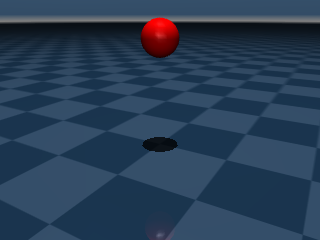

In [6]:
all_variables = dir()
for name in all_variables:
    
    # Print the item if it doesn't start with '__'
    if not name.startswith('__'):
        if name == 'renderer':
            del renderer
        elif name == 'xml':
            del xml
        elif name == 'model':
            del model
        elif name == 'data':
            del data

with open('./model/Adding-World-Bodies-Bounce/adding_world_bodies.xml', 'r') as f:
  xml = f.read()
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

### Using mj_step to render a sequence of frames of the simulation

In [7]:
duration = 3.8  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

As you can see above the ball did not bounce in the last session's example but in today's example it does. This is because we have set the property solref
in the mjcf file. 

Now is a good time to talk about constraint solver in MuJoCo. 

In [8]:
[model.geom(i).name for i in range(model.ngeom)]

['floor', 'body']

solref can be used to set the reference acceleration in the constraint space, where 

$$ m\ddot{x} + \tilde{b}\dot{x} + \tilde{k}x = \tilde{Q}$$

where $\tilde{Q}$ is the constraint violation force

so, 

$$\ddot{x} = \frac{1}{m}(\tilde{Q} - \tilde{b}\dot{x} - \tilde{k}x)$$

let the force violation be negligibly small, then :

$$\ddot{x} = - \frac{\tilde{b}}{m}\dot{x} - \frac{\tilde{k}x}{m}$$

$$\ddot{x} = -b(v) - kx$$

let, $a^{*} = -b(v)-kx$

here $b$ is damping and $k$ is stiffness and $a^{*}$ is the reference acceleration in the constraint space.
 

In [9]:
for i in range(model.ngeom):
    print(model.geom(i).solref) 


[1.  0.1]
[0.0001 0.001 ]


In [10]:
model.geom(0).solref = [-1000, -0]
model.geom(1).solref = [-1000, -0]

You can notice that [-1000, 0] for solref value means that it is a perfectly elastic collision(cooresponding to the zero damping value) and of stiffness 1000 at the point of contact.

In the original MJCF of this example you can see the values set in "timeconstant dampratio" format

In [11]:
del renderer
renderer = mujoco.Renderer(model)

frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

now let us look at what solimp does to our simulation.

In [12]:
model.geom(0).solimp = [0.9899, 0.99, 1, 0.0001, 1]
model.geom(1).solimp = [0.9899, 0.99, 1, 0.0001, 1]

In [13]:
del renderer
renderer = mujoco.Renderer(model)

frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

you can see that our choice of solimp is violating the surface constraints of the geoms sufficiently to allow penetration.

In [14]:
print('Total number of DoFs in the model:', model.nv)
print('Generalized positions:', data.qpos) #position and orientation in quaternions
print('Generalized velocities:', data.qvel) #velocity

Total number of DoFs in the model: 6
Generalized positions: [0.         0.         0.24349169 1.         0.         0.
 0.        ]
Generalized velocities: [ 0.          0.         -4.87652363  0.          0.          0.        ]


Let us explore joints in mujoco now. We will try to explore all joint types mentioned in the slides from the previous session using primitive joints in mujoco.


### The Revolute Joint

""

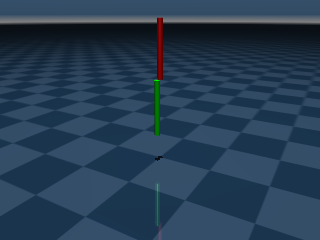

In [26]:
# del xml, model, data, renderer
with open('./model/Joints/planar_double_pendulum.xml', 'r') as f:
  xml = f.read()
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

In [27]:
duration = 3.8  # (seconds)
framerate = 60  # (Hz)


# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
data.qpos[0] = 2
data.qpos[1] = 1
#set joint axis view flag to true
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

### The Universal Joint

universal joint is 2 orthogonally intersecting(stacked) revolute joints

""

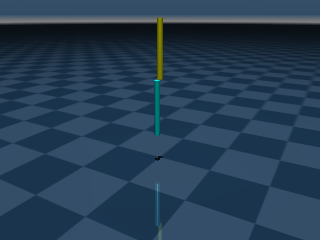

In [17]:
del xml, model, data, renderer
with open('./model/Joints/spatial_double_pendulum.xml', 'r') as f:
  xml = f.read()
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

In [18]:
duration = 5.8  # (seconds)
framerate = 60  # (Hz)


# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
data.qpos[0] = 1
data.qpos[1] = 2
#set joint axis view flag to true
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

### The Prismatic Joint

In [28]:
!python3 -m mujoco.viewer --mjcf="./model/Joints/magic_ball.xml"

### The Ball Joint

In [29]:
!python3 -m mujoco.viewer --mjcf="./model/Joints/spinning_box.xml"

""

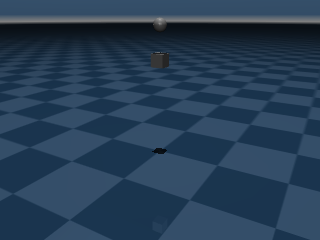

In [32]:
all_variables = dir()
for name in all_variables:
    
    # Print the item if it doesn't start with '__'
    if not name.startswith('__'):
        if name == 'renderer':
            del renderer
        elif name == 'xml':
            del xml
        elif name == 'model':
            del model
        elif name == 'data':
            del data
import mujoco
import mediapy as media
with open('./model/ContypeConaffinity/contactfilter.xml', 'r') as f:
  xml = f.read()
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

mujoco.mj_forward(model, data)
renderer.update_scene(data, camera="closeup")
media.show_image(renderer.render())

In [33]:
duration = 7    # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetDataKeyframe(model, data, 0)  # Reset the state to keyframe 0
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data, "closeup")
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=framerate)

In [23]:
import numpy as np
n_frames = 500
height = 240
width = 320
frames = []
all_variables = dir()
for name in all_variables:
    
    # Print the item if it doesn't start with '__'
    if not name.startswith('__'):
        if name == 'renderer':
            del renderer
renderer = mujoco.Renderer(model, height, width)

# visualize contact frames and forces, make body transparent
options = mujoco.MjvOption()
mujoco.mjv_defaultOption(options)
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
options.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True

# tweak scales of contact visualization elements
model.vis.scale.contactwidth = 0.1
model.vis.scale.contactheight = 0.03
model.vis.scale.forcewidth = 0.05
model.vis.map.force = 0.3

# random initial rotational velocity:
mujoco.mj_resetData(model, data)
data.qvel[3:6] = 5*np.random.randn(3)

# simulate and render
for i in range(n_frames):
  while data.time < i/60.0: #1/4x real time
    mujoco.mj_step(model, data)
  renderer.update_scene(data, "track", options)
  frame = renderer.render()
  frames.append(frame)

# show video
media.show_video(frames, fps=30)

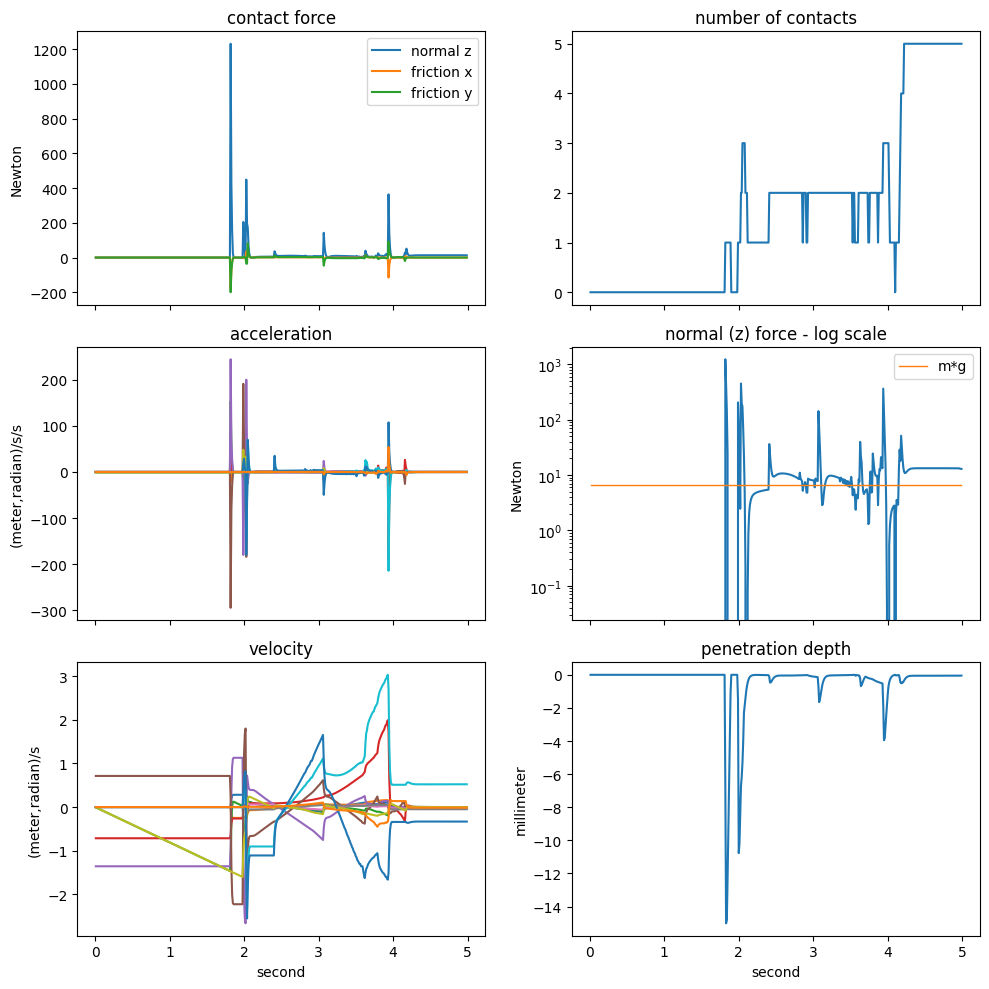

In [24]:
all_variables = dir()
for name in all_variables:
    
    # Print the item if it doesn't start with '__'
    if not name.startswith('__'):
        if name == 'renderer':
            del renderer


n_steps = 499

# allocate
sim_time = np.zeros(n_steps)
ncon = np.zeros(n_steps)
force = np.zeros((n_steps,3))
velocity = np.zeros((n_steps, model.nv))
penetration = np.zeros(n_steps)
acceleration = np.zeros((n_steps, model.nv))
forcetorque = np.zeros(6)

# random initial rotational velocity:
mujoco.mj_resetData(model, data)
data.qvel[3:6] = 2*np.random.randn(3)

# simulate and save data
for i in range(n_steps):
  mujoco.mj_step(model, data)
  sim_time[i] = data.time
  ncon[i] = data.ncon
  velocity[i] = data.qvel[:]
  acceleration[i] = data.qacc[:]
  # iterate over active contacts, save force and distance
  for j,c in enumerate(data.contact):
    mujoco.mj_contactForce(model, data, j, forcetorque)
    force[i] += forcetorque[0:3]
    penetration[i] = min(penetration[i], c.dist)
  # we could also do
  # force[i] += data.qfrc_constraint[0:3]
  # do you see why?

# plot
_, ax = plt.subplots(3, 2, sharex=True, figsize=(10, 10))

lines = ax[0,0].plot(sim_time, force)
ax[0,0].set_title('contact force')
ax[0,0].set_ylabel('Newton')
ax[0,0].legend(iter(lines), ('normal z', 'friction x', 'friction y'));

ax[1,0].plot(sim_time, acceleration)
ax[1,0].set_title('acceleration')
ax[1,0].set_ylabel('(meter,radian)/s/s')

ax[2,0].plot(sim_time, velocity)
ax[2,0].set_title('velocity')
ax[2,0].set_ylabel('(meter,radian)/s')
ax[2,0].set_xlabel('second')

ax[0,1].plot(sim_time, ncon)
ax[0,1].set_title('number of contacts')
ax[0,1].set_yticks(range(6))

ax[1,1].plot(sim_time, force[:,0])
ax[1,1].set_yscale('log')
ax[1,1].set_title('normal (z) force - log scale')
ax[1,1].set_ylabel('Newton')
z_gravity = -model.opt.gravity[2]
mg = model.body("random1").mass[0] * z_gravity
mg_line = ax[1,1].plot(sim_time, np.ones(n_steps)*mg, label='m*g', linewidth=1)
ax[1,1].legend()

ax[2,1].plot(sim_time, 1000*penetration)
ax[2,1].set_title('penetration depth')
ax[2,1].set_ylabel('millimeter')
ax[2,1].set_xlabel('second')

plt.tight_layout()